# Processing of the Data Science Bowl 2018 kaggle dataset with u-net neural network

In [15]:
%matplotlib inline 
import matplotlib
import keras
import sys
import os
from glob import glob
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("data")
from data.data_helper import show_data_from_generator
from models.unet import *
from data.dsb import DataScienceBowl2018
from data.dataset import Dataset
from callbacks import ImageHistory
import seaborn as sns

## Directories

In [2]:
# location where the dataset will be downloaded
dataset_location = './data/datasets/data-science-bowl-2018'
weight_file = './unet_dsb_weights.hdf5'

## Parameters

In [3]:
input_shape=(256,256,1)

In [4]:
dataset = DataScienceBowl2018(dataset_location)

## Build model

In [5]:
builder = Unet(input_shape=input_shape)
model = builder.build_model()

## Load weights

In [6]:
model.load_weights(weight_file)

## Explore results

In [7]:
def generate_segmentation_mask(model, dataset, image):
    mean = np.mean(image)
    if mean>80:
        image = (255 - image)
    image_tiles = dataset.split_image_to_tiles(image)
    tile_num = len(image_tiles)
    tile_shape = image_tiles[0].shape
    batch = np.zeros((tile_num, tile_shape[0], tile_shape[1], 1))
    for tile_index in range(tile_num):
        tile = image_tiles[tile_index]
        tile = Dataset.normalize_image(tile)
        batch[tile_index,:,:,0] = tile
    mask_batch = model.predict(batch)
    mask_tiles = []
    for tile_index in range(tile_num):
        tile = mask_batch[tile_index,:,:,0]
        mask_tiles.append(tile)
    mask = dataset.combine_image_from_tiles(image.shape, mask_tiles)
    return mask

In [20]:
def show_test_prediction(number_of_test_images, error_threshold, show_diff=False):
    t_generator = dataset.generator('test', batch_size=1)

    cols = 10
    rows = (number_of_test_images-1)//cols + 1
    if cols > number_of_test_images:
        cols = number_of_test_images
        
    subrows = 3
    if show_diff:
        subrows = 4

    plt.figure(figsize=(5*cols, 15*rows))
    item = 0
    for image, label in t_generator:
        mask = generate_segmentation_mask(model, dataset, image)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        label1 = Dataset.normalize_label(label)
        pixel_dif = np.sum(np.abs(mask - label1))/(image.shape[0]*image.shape[1]/100)
        if pixel_dif>=error_threshold:
            row = item//cols
            col = item%cols
            plt.subplot2grid((rows*subrows,cols),(row*subrows, col))
            plt.xticks([])
            plt.yticks([])
            plt.title('error=' + str(pixel_dif))
            plt.imshow(image,cmap='gray')
            plt.subplot2grid((rows*subrows,cols),(row*subrows+1, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(label1,cmap='gray')
            plt.subplot2grid((rows*subrows,cols),(row*subrows+2, col))
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask,cmap='gray')
            if show_diff:
                plt.subplot2grid((rows*subrows,cols),(row*subrows+3, col))
                plt.xticks([])
                plt.yticks([])
                diff = np.abs(label1 - mask)
                plt.imshow(diff,cmap='gray')
            item += 1
        if item>=number_of_test_images:
            break
    plt.show()
    

In [11]:
def compute_test_errors(number_of_test_images):
    t_generator = dataset.generator('test', batch_size=1)
    item = 0
    diffs = []
    for image, label in t_generator:
        mask = generate_segmentation_mask(model, dataset, image)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        label1 = Dataset.normalize_label(label)
        pixel_dif = np.sum(np.abs(mask - label1))/(image.shape[0]*image.shape[1]/100)
        diffs.append(pixel_dif)
    return diffs

In [13]:
errors = compute_test_errors(67)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


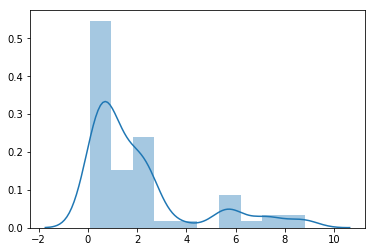

In [16]:
sns.distplot(errors)

In [18]:
np.mean(errors),np.min(errors),np.max(errors)

(2.0434532678507145, 0.0823974609375, 8.82080078125)

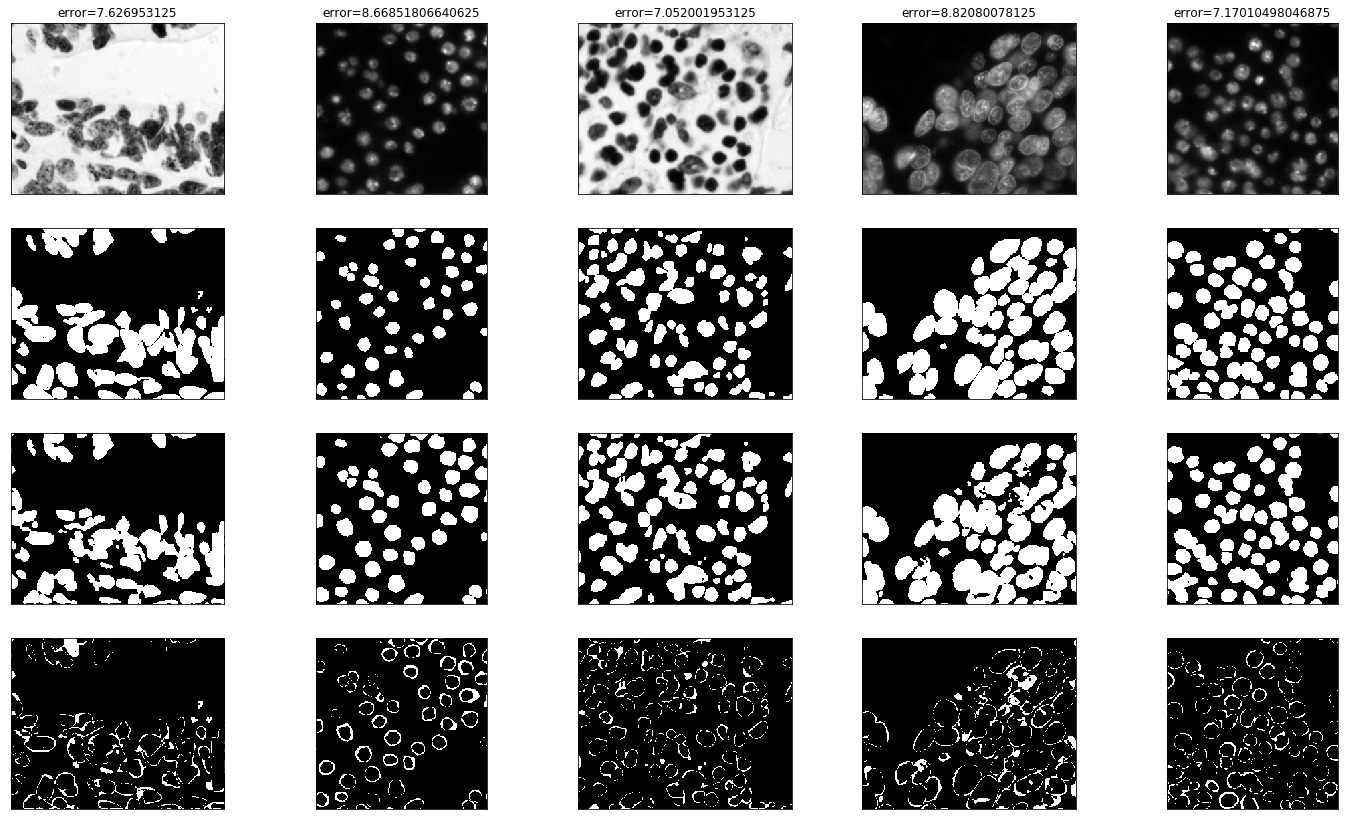

In [23]:
show_test_prediction(67, 6, True)

### Generate segmentation masks

Show first 30 images from the training set

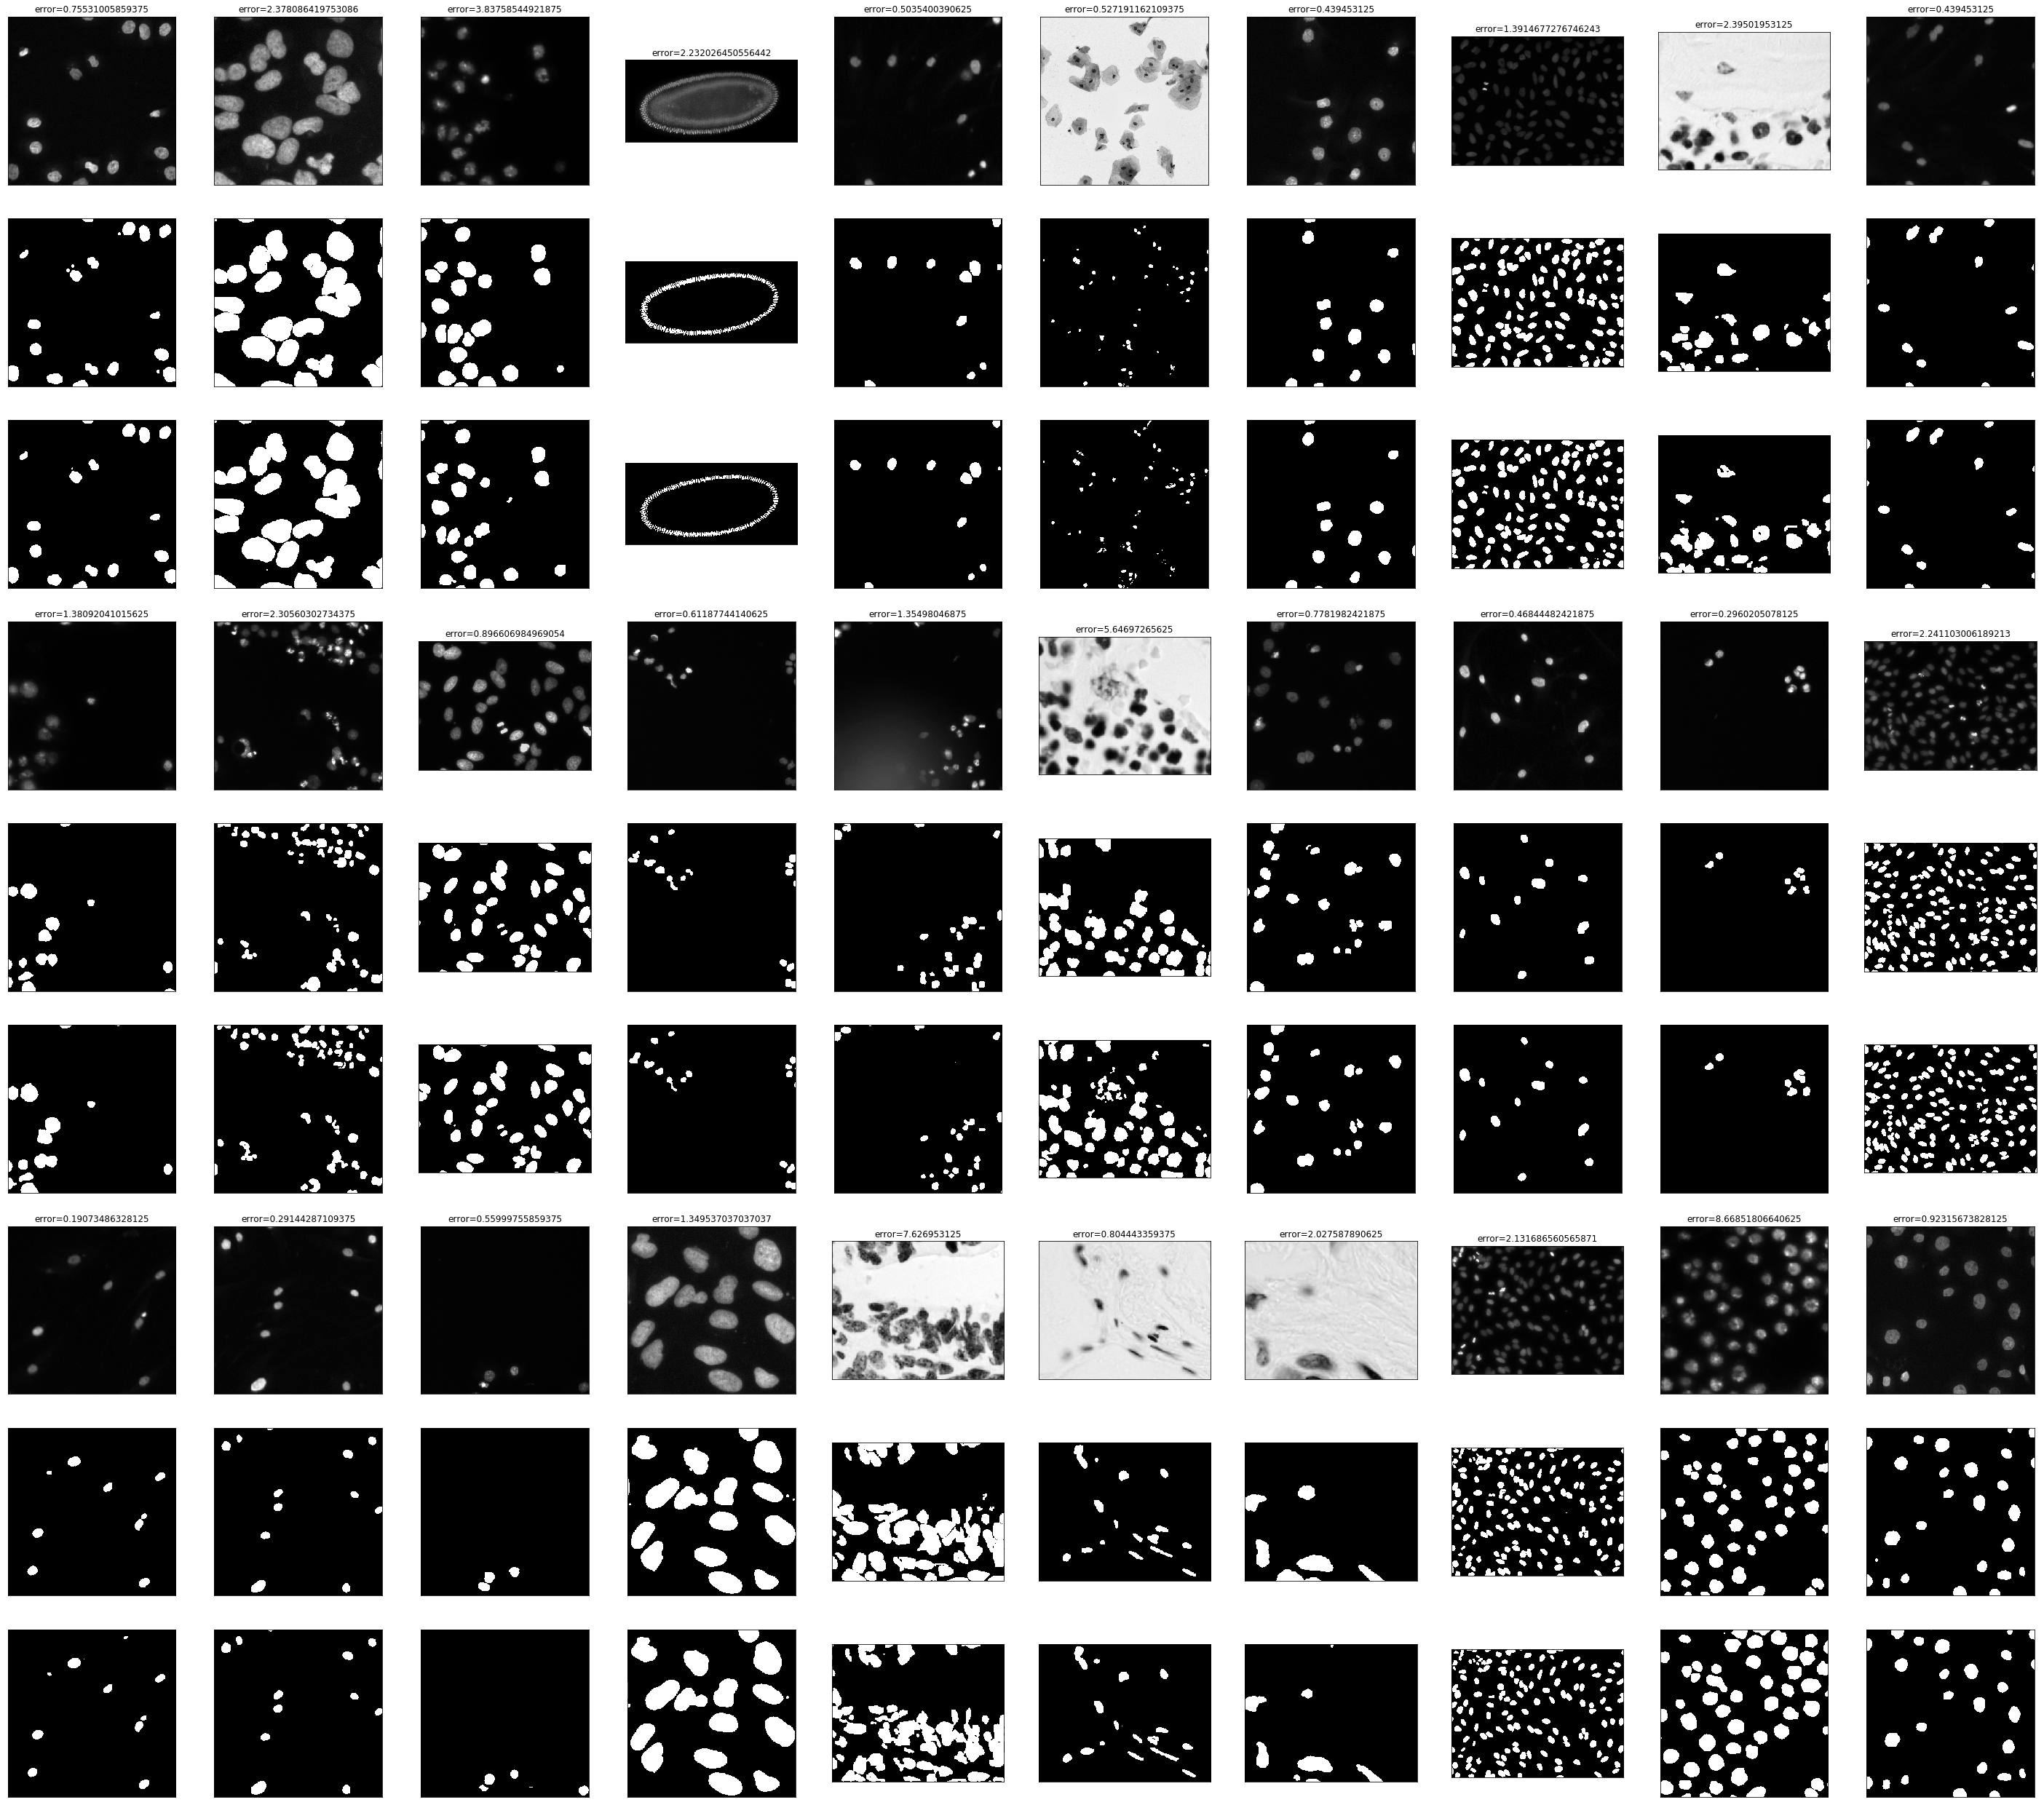

In [9]:
show_test_prediction(30, 0)

Show images with pixel error more than 5%

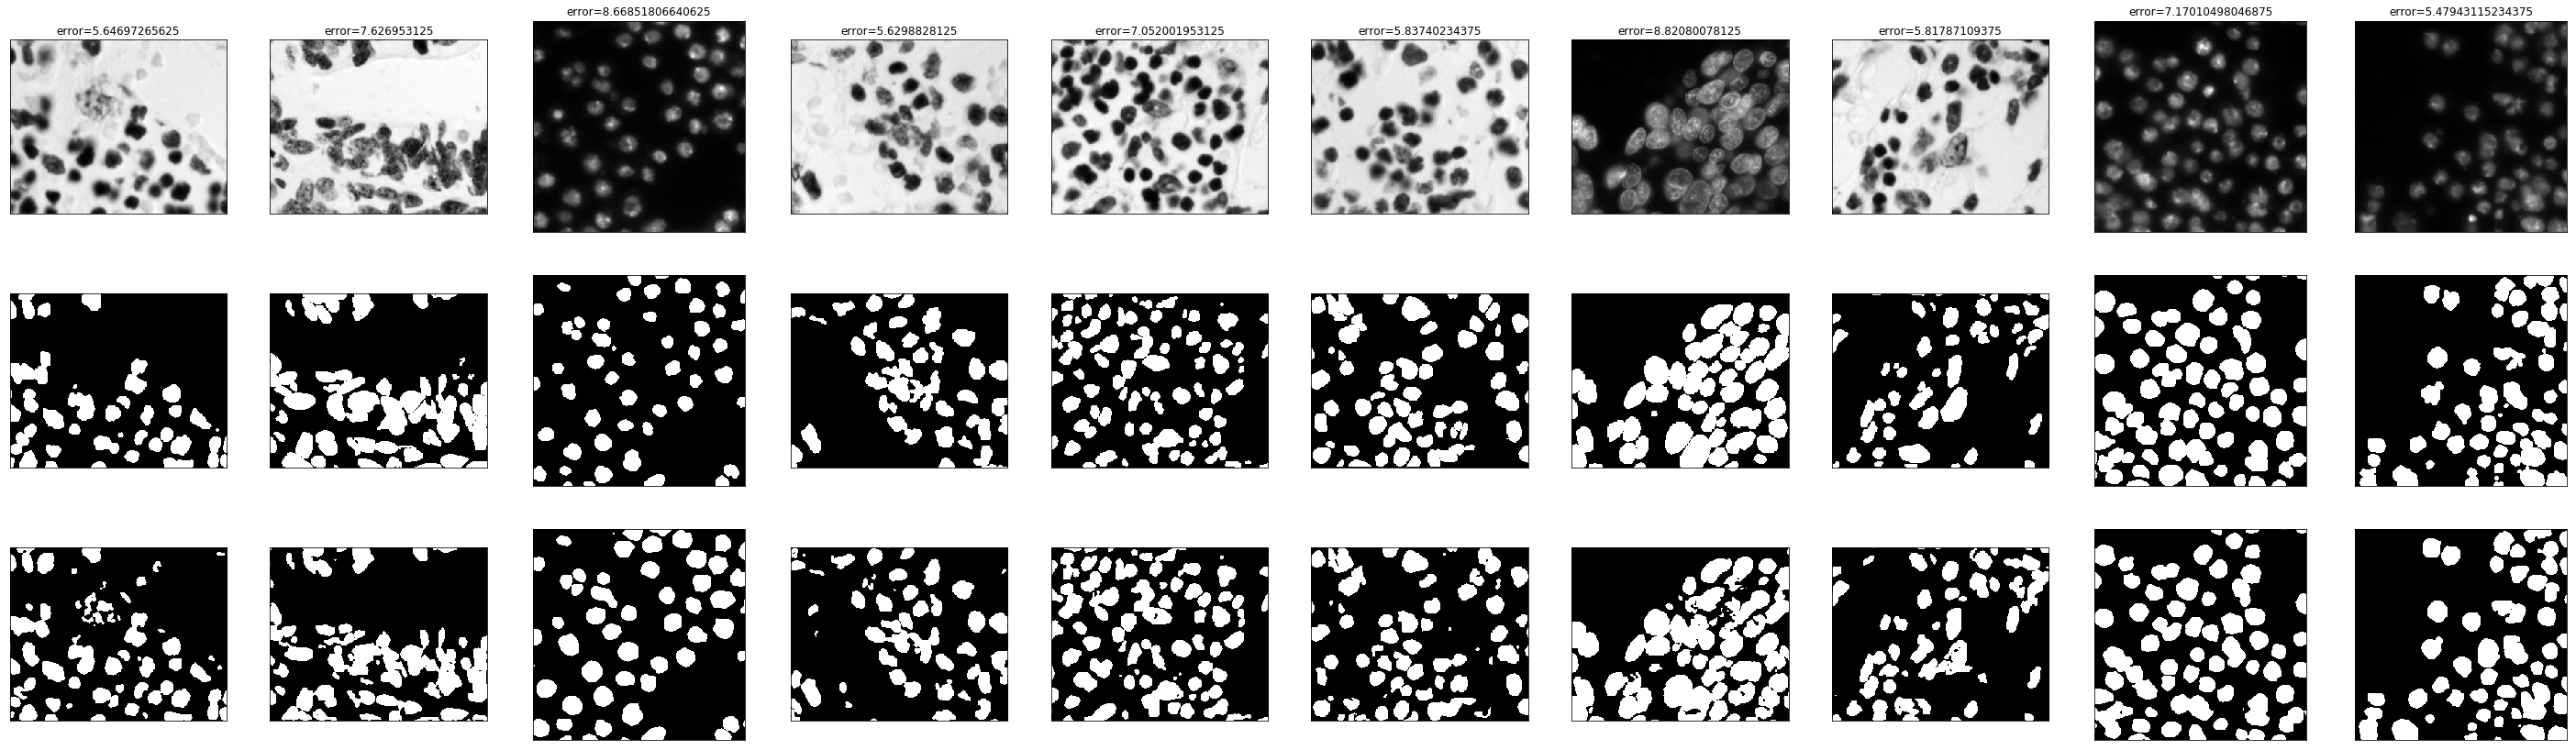

In [26]:
show_test_prediction(30, 5)